<a href="https://colab.research.google.com/github/iamklacs97/Personal_Projects/blob/main/Final_project_Covid_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS654 - Covid Classification

### Kyle Lacson and Esther Laub

Training a CNN on covid and non-covid infected lung images. The goal here is to develop a working CNN that is able execute under an hour (using google colabs GPU or a single GPU - M1 Pro Chip).

### 1.1 Importing libraries and packages

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

from google.colab import drive
import os,shutil
import warnings
warnings.filterwarnings('ignore')

### 1.2 Mounting Google Drive

In [ ]:
drive.mount('/content/gDrive')

Drive already mounted at /content/gDrive; to attempt to forcibly remount, call drive.mount("/content/gDrive", force_remount=True).


In [ ]:
for dir, root, files in os.walk(os.getcwd()):
  print(dir)

/content
/content/.config
/content/.config/configurations
/content/.config/logs
/content/.config/logs/2023.04.19
/content/gDrive
/content/gDrive/Shareddrives
/content/gDrive/MyDrive
/content/gDrive/MyDrive/Colab Notebooks
/content/gDrive/MyDrive/Colab Notebooks/Assignments
/content/gDrive/MyDrive/School
/content/gDrive/MyDrive/School/ADS654Z1
/content/gDrive/MyDrive/School/ADS654Z1/sel_images
/content/gDrive/MyDrive/School/ADS654Z1/Final_project
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/.ipynb_checkpoints
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train/Covid
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train/Non_Covid
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test
/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test/Covid
/content/gDrive/MyDrive/School/ADS654Z1/Final_p

In [ ]:
main_dir = r'/content/gDrive/MyDrive/School/ADS654Z1/Final_project/'

In [ ]:
for dir, root, files in os.walk(main_dir):
  print(root)

['archive', 'Covid_Images', 'Heart_segmentation']
['.ipynb_checkpoints', 'Train', 'Test']
[]
['Covid', 'Non_Covid']
[]
[]
['Covid', 'Non_Covid']
[]
[]
['non-COVID', 'COVID', '.ipynb_checkpoints']
[]
[]
[]
['imagesTr', 'imagesTs', 'labelsTr']
[]
[]
[]


In [ ]:
image_dir = os.path.join(main_dir,'Covid_Images')
train_test_dir = os.path.join(main_dir,'archive')

### 1.3 Setting up proper directories for training and test datasets

**Make new directory for training and test images**

In [ ]:
def make_new_dir():
  os.chdir(train_test_dir) # change working directory
  if os.path.exists(os.path.abspath('Train')) & os.path.exists(os.path.abspath('Test')):
    pass
  elif (os.path.exists(os.path.abspath('Train')) == True) & (os.path.exists(os.path.abspath('Test')) == False):
    os.mkdir('Test')
  elif (os.path.exists(os.path.abspath('Train')) == False) & (os.path.exists(os.path.abspath('Test')) == True):
    os.mkdir('Train')
  else:
    os.mkdir('Train')
    os.mkdir('Test')

# make_new_dir()

In [ ]:
train_dir = os.path.abspath('Train')
test_dir = os.path.abspath('Test')

**Make subdirectories in train and test directories**

In [ ]:
def make_train_subdirs():
  os.chdir(train_dir)
  os.mkdir('Covid')
  os.mkdir('Non_Covid')

def make_test_subdirs():
  os.chdir(test_dir)
  os.mkdir('Covid')
  os.mkdir('Non_Covid')

# make_train_subdirs()
# make_test_subdirs()

In [ ]:
os.chdir(main_dir)# returning to project directory

**Image directory for covid and non-covid images**

In [ ]:
covid_dir = os.path.join(image_dir,'COVID')
noncovid_dir = os.path.join(image_dir,'non-COVID')

**Number of images for covid and non-covid**

In [ ]:
print(f'Number of covid images: {len(os.listdir(covid_dir))} \nNumber of non-covid images: {len(os.listdir(noncovid_dir))}')

Number of covid images: 1252 
Number of non-covid images: 1229


**Need transfer images into training and testing datasets, need to figure out which dataset is missing any images within the range.**

In [ ]:
# framework for filename - "Covid (###).png"
def covid_file_check():
  true = 0
  false = 0
  missing_covid_files = []
  for i in range(len(os.listdir(covid_dir))+1):
    if f'Covid ({i}).png' in os.listdir(covid_dir):
      true += 1
    else:
      false +=1
      print(f'Image {i}')
      missing_covid_files.append(i)
  print(f'Total covid images: {(true+false)-1}')
  return missing_covid_files

missing_covid_files = covid_file_check()

Image 0
Total covid images: 1252


In [ ]:
# framework for filename - "Non-Covid (###).png"
def noncovid_file_check():
  true = 0
  false = 0
  missing_noncovid_files = []
  for i in range(len(os.listdir(noncovid_dir))+1):
    if f'Non-Covid ({i}).png' in os.listdir(noncovid_dir):
      true += 1
    else:
      false += 1
      print(f'Image {i}')
      missing_noncovid_files.append(i)
  print(f'Total noncovid images: {(true+false)-1}')
  return missing_noncovid_files

missing_noncovid_files = noncovid_file_check()

Image 0
Image 151
Total noncovid images: 1229


In [ ]:
os.chdir(main_dir) # changing back to wd
os.getcwd()

'/content/gDrive/MyDrive/School/ADS654Z1/Final_project'

### 1.4 Splitting the training and testing data set

**Plan is to use 20% for test data set -> will take 20% from covid datasets**

In [ ]:
covid_dir

'/content/gDrive/MyDrive/School/ADS654Z1/Final_project/Covid_Images/COVID'

In [ ]:
print(f'20% of covid images that will be used for testing: {round(len(os.listdir(covid_dir))*0.20,0)}')
len(os.listdir(covid_dir)) - 250 # training images

20% of covid images that will be used for testing: 250.0


1002

**There are no missing covid files within the full range of covid images**

In [ ]:
missing_covid_files # no missing images in range

[0]

In [ ]:
### Training covid images list
def covid_training_img_list(): # no restrictions
  covid_train_imgs_list = []
  for ix,i in enumerate(range(1002+1)): 
    if ix == 0:
      continue
    else:
      src_fname = f'Covid ({i}).png'
      covid_train_imgs_list.append(src_fname)
  return covid_train_imgs_list

def covid_test_img_list():
  covid_test_imgs_list = []
  for ix,i in enumerate(range(1003,1253)):
    src_fname = f'Covid ({i}).png'
    covid_test_imgs_list.append(src_fname)
  return covid_test_imgs_list

covid_train_imgs_list = covid_training_img_list()
covid_test_imgs_list = covid_test_img_list()

**Plan is to use 20% for test data set -> will take 20% from non-covid datasets**

In [ ]:
noncovid_dir

'/content/gDrive/MyDrive/School/ADS654Z1/Final_project/Covid_Images/non-COVID'

In [ ]:
print(f'20% of covid images that will be used for testing: {round(len(os.listdir(noncovid_dir))*0.20,0)}')
len(os.listdir(noncovid_dir)) - 246 # training images

20% of covid images that will be used for testing: 246.0


983

**There is one missing covid file image within the full range of covid images**

In [ ]:
missing_noncovid_files # one missing image in range

[0, 151]

In [ ]:
def noncovid_training_img_list():
  noncovid_train_imgs_list = []
  for ix,i in enumerate(range(983+1)):
    if i in missing_noncovid_files:
      continue
    else:
      src_fname = f'Non-Covid ({i}).png'
      noncovid_train_imgs_list.append(src_fname)
  return noncovid_train_imgs_list

def noncovid_testing_img_list():
  noncovid_test_imgs_list = []
  for ix,i in enumerate(range(984,1231)): # range should be from image 984 to 1229
    src_fname = f'Non-Covid ({i}).png'
    noncovid_test_imgs_list.append(src_fname)
  return noncovid_test_imgs_list

noncovid_train_imgs_list = noncovid_training_img_list()
noncovid_test_imgs_list = noncovid_testing_img_list()

**Checking that the directories contain all image filenamese**

In [ ]:
print(f'Total covid images: {len(covid_train_imgs_list) + len(covid_test_imgs_list)}')
print(f'Total noncovid images: {len(noncovid_train_imgs_list) + len(noncovid_test_imgs_list)}')

Total covid images: 1252
Total noncovid images: 1229


In [ ]:
noncovid_train_imgs_list[-5:], noncovid_test_imgs_list[:5]

(['Non-Covid (979).png',
  'Non-Covid (980).png',
  'Non-Covid (981).png',
  'Non-Covid (982).png',
  'Non-Covid (983).png'],
 ['Non-Covid (984).png',
  'Non-Covid (985).png',
  'Non-Covid (986).png',
  'Non-Covid (987).png',
  'Non-Covid (988).png'])

In [ ]:
# checking to what the last file names are for noncovid tests...
def digit_finder(list_input):
  number = []
  for i in list_input:
    if i.isdigit():
      number.append(i)
    else:
      continue
  return int(''.join(number))

non_list = []  
for i in os.listdir(noncovid_dir):
  num = digit_finder(i)
  non_list.append(num)

In [ ]:
non_list.sort()
non_list[-5:]

[1226, 1227, 1228, 1229, 1230]

*Notes:* Generating list of names was successfully created. Can now use the shutil package to copy over images into their respective directories...

### 1.5 Moving images into subdirectories

In [ ]:
### from covid_dir -> train_dir & test_dir 
### from noncovid_dir -> train_dir & test_dir
os.chdir(train_test_dir)
os.getcwd() # changing working directory

'/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive'

In [ ]:
train_dir = os.path.join(train_test_dir,'Train') # model training directory (archive)
test_dir = os.path.join(train_test_dir,'Test') # model testing directory (archive)

In [ ]:
### covid_train_imgs_list, covid_test_imgs_list
### noncovid_train_imgs_list, noncovid_train_imgs_list
len(covid_train_imgs_list) + len(covid_test_imgs_list), len(noncovid_train_imgs_list) + len(noncovid_test_imgs_list)

(1252, 1229)

**Covid Image Transfer**

In [ ]:
train_dir, test_dir

('/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train',
 '/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test')

In [ ]:
# covid train
def covid_train_transfer():
  for ix,i in enumerate(covid_train_imgs_list): # covid training images
    src = os.path.join(covid_dir,i)
    dst = os.path.join(train_dir,'Covid',i) # covid subdir in train
    shutil.copy(src,dst)

# covid test
def covid_test_transfer():
  for ix,i in enumerate(covid_test_imgs_list): # covid test images
    src = os.path.join(covid_dir,i)
    dst = os.path.join(test_dir,'Covid',i) # covid subdir in test
    shutil.copy(src,dst)

In [ ]:
# covid_train_transfer()
# covid_test_transfer() # ~ 10 min runtime

**Noncovid Image Transfer**

In [ ]:
# noncovid train
def noncovid_train_transfer():
  for ix,i in enumerate(noncovid_train_imgs_list): # covid training images
    src = os.path.join(noncovid_dir,i)
    dst = os.path.join(train_dir,'Non_Covid',i) # covid subdir in train
    shutil.copy(src,dst)

# noncovid test
def noncovid_test_transfer():
  for ix,i in enumerate(noncovid_test_imgs_list): # covid test images
    src = os.path.join(noncovid_dir,i)
    dst = os.path.join(test_dir,'Non_Covid',i) # covid subdir in test
    shutil.copy(src,dst)

In [ ]:
# noncovid_train_transfer() ~ 8 mins runtime

In [ ]:
# noncovid_test_transfer() ~ 2 mins runtime

In [ ]:
for dir,root,files in os.walk(train_dir):
  print(f'Directory Name: {dir}  |   Number of images: {len(files)}')

Directory Name: /content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train  |   Number of images: 0
Directory Name: /content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train/Covid  |   Number of images: 1002
Directory Name: /content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train/Non_Covid  |   Number of images: 982


In [ ]:
for dir,root,files in os.walk(test_dir):
  print(f'Directory Name: {dir}   |   Number of images: {len(files)}')

Directory Name: /content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test   |   Number of images: 0
Directory Name: /content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test/Covid   |   Number of images: 250
Directory Name: /content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test/Non_Covid   |   Number of images: 247


In [ ]:
1002+250,982+247 # All images has been transferred

(1252, 1229)

### 2.1 Importing Images from directory 

In [ ]:
train_dir

'/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Train'

**Train images** 

With validation split

In [ ]:
train_batch = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir, # not sure what input is needed for this attribute
    seed = 42,
    validation_split = 0.2, # fracction of data reserved for validation
    subset = 'training' # not sure if this should be training, validation or both
)

Found 1984 files belonging to 2 classes.
Using 1588 files for training.


**Test images**

In [ ]:
test_dir

'/content/gDrive/MyDrive/School/ADS654Z1/Final_project/archive/Test'

In [ ]:
test_batch = tf.keras.utils.image_dataset_from_directory(
    directory = test_dir,
    seed = 42
)

Found 497 files belonging to 2 classes.


In [ ]:
train_batch.class_names, test_batch.class_names

(['Covid', 'Non_Covid'], ['Covid', 'Non_Covid'])

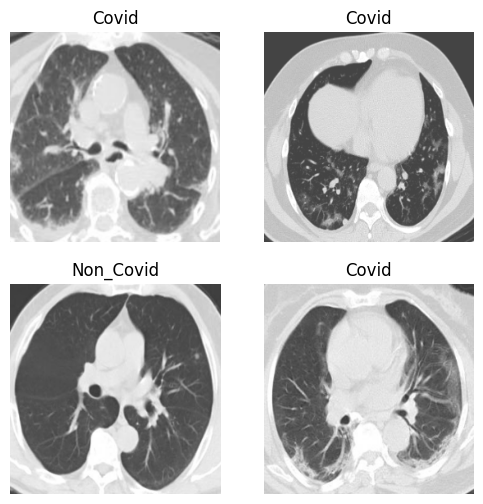

In [ ]:
fig = plt.figure(figsize = (6,6))
for imgs,labels in train_batch.take(1):
  for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(imgs[i].numpy().astype('int'))
    plt.title(train_batch.class_names[labels[i]])
    plt.axis('off')

### 2.2 Preparing the training images and label iterator

In [ ]:
train_images,train_labels = next(iter(train_batch))

### 3.1 Build CNN Model

In [ ]:
input_layer = tf.keras.Input(shape = train_images.shape[1:], name = 'input_layer')
rescale_layer = tf.keras.layers.Rescaling(scale = 1./255, name = 'rescaling_layer')(input_layer) ### maybe add a padding layer?
conv_layerb1_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv2d_layerb1_1')(rescale_layer)
conv_layerb1_2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv2d_layerb1_2')(conv_layerb1_1)
pool_layerb1_1 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name = 'max_pool_layerb1_1')(conv_layerb1_2)
batch_norm_layer1 = tf.keras.layers.BatchNormalization(name = 'batch_norm_layer1')(pool_layerb1_1)
#continue pattern

In [ ]:
cnn_model = tf.keras.Model(inputs = input_layer, outputs = batch_norm_layer1, name = 'kl_el_cnn_modelv1')

In [ ]:
cnn_model.summary()

Model: "kl_el_cnn_modelv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 conv2d_layerb1_1 (Conv2D)   (None, 256, 256, 32)      896       
                                                                 
 conv2d_layerb1_2 (Conv2D)   (None, 256, 256, 32)      9248      
                                                                 
 max_pool_layerb1_1 (MaxPool  (None, 128, 128, 32)     0         
 ing2D)                                                          
                                                                 
 batch_norm_layer1 (BatchNor  (None, 128, 128, 32)     128       
 malization)                                     

*Notes:* Can add data augmentation, dropout layers, or batch normalization to combat overfitting

- Will need to flatten, dense layer, and the output should be a single output using some kind of classificaiton activation function -> sigmoid should be fine

- Adding more padding layers should increase overall model accuracy

In [ ]:
# resnet50_model = tf.keras.applications.ResNet50()
#     include_top = True
# )

102967424/102967424 [==============================] - 4s 0us/step


In [ ]:
# resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           